# Spam Classification Under Semi-supervised Settings

This code is partly based on https://www.kaggle.com/kredy10/simple-lstm-for-text-classification

## First things first

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from nltk.tokenize import word_tokenize


In [99]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

In [100]:
import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence # for efficient computation of rnns
# https://simonjisu.github.io/nlp/2018/07/05/packedsequence.html

In [101]:
from time import time
import copy
import random
random.seed(1)

## Settings

In [135]:
VOCAB_SIZE=1000
MAXLEN=150 # maximum sequence length
BATCH_SIZE=64
UPSAMPLE=True
VAT=True

## Data

Download SMS Spam Collection Dataset from https://www.kaggle.com/uciml/sms-spam-collection-dataset

Load the data into Pandas dataframe

In [103]:
df = pd.read_csv('spam.csv', sep=",", encoding="latin-1")
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


Drop the columns that are not required for the neural network.

In [104]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],axis=1,inplace=True)
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [105]:
sents = df["v2"].tolist() # inputs
labels = df["v1"].tolist() # targets

Normalize text

In [106]:
def normalize(sent):
    sent = sent.lower()
    words = word_tokenize(sent)
    return words

sents = [normalize(sent) for sent in sents]

## Let's create train and test sets






First, divide data into training and test sets.

In [107]:
sents_train, sents_test, labels_train, labels_test = train_test_split(sents, labels, test_size=.2, shuffle=True)

Next, further divide training samples into labeled and unlabeled.

In [108]:
sents_train, sents_ul, labels_train, labels_ul = train_test_split(sents_train, labels_train, test_size=.8, shuffle=True)

Let's see how many spams are in the training/unlabeled/test data.

In [109]:
print("There are {} training samples ({} spams, {} hams), \n\
{} unlabeled samples ({} spams, {} hams), \n\
and {} test samples ({} spams, {} hams)".format\
      (len(labels_train), labels_train.count("spam"), labels_train.count("ham"),\
       len(labels_ul), labels_ul.count("spam"), labels_ul.count("ham"),\
       len(labels_test), labels_test.count("spam"), labels_test.count("ham")\
      )
     )

There are 891 training samples (116 spams, 775 hams), 
3566 unlabeled samples (487 spams, 3079 hams), 
and 1115 test samples (144 spams, 971 hams)


## Set Vocabulary

Include the most frequent n words in vocabulary.

In [110]:
from collections import Counter
words = [word for sent in sents_train for word in sent]
word2cnt = Counter(words)
vocab = [w for w, c in word2cnt.most_common(len(word2cnt))]

In [111]:
vocab = ["<PAD>", "<EOS>", "<UNK>"] + vocab
vocab = vocab[:VOCAB_SIZE]

Vocabulary looks like ..

In [112]:
vocab[:10]

['<PAD>', '<EOS>', '<UNK>', '.', 'i', 'to', 'you', ',', '?', '!']

dictionary

In [113]:
word2idx = {word:idx for idx, word in enumerate(vocab)}
idx2word = {idx:word for idx, word in enumerate(vocab)}

## Encode

### Y or labels

In [114]:
def encode_labels(labels):
    return [1 if l=="spam" else 0 for l in labels ]

In [115]:
_Y_train = encode_labels(labels_train)
_Y_ul = encode_labels(labels_ul) # actually this is not needed.
_Y_test = encode_labels(labels_test)

### X or inputs

In [116]:
def encode_sents(sents):
    X = [] # whole input data encoded
    for sent in sents: 
        sent += ["<EOS>"]
        sent += ["<PAD>"]*MAXLEN 
        x = [word2idx.get(word, 2) for word in sent[:MAXLEN]] # 2:<UNK>
        X.append(x)
    return X

In [117]:
_X_train = encode_sents(sents_train)
_X_ul = encode_sents(sents_ul)
_X_test = encode_sents(sents_test)

### Upsampling

In [118]:
if UPSAMPLE:
    from imblearn.over_sampling import SMOTE
    # https://arxiv.org/pdf/1106.1813.pdf
    
    ros = SMOTE(random_state=0)
    _X_train, _Y_train = ros.fit_resample(_X_train, _Y_train) 

### Convert to tensors

In [119]:
X_train = torch.LongTensor(_X_train)
X_ul = torch.LongTensor(_X_ul)
X_test = torch.LongTensor(_X_test)

Y_train = torch.LongTensor(_Y_train)
Y_ul = torch.LongTensor(_Y_ul)
Y_test = torch.LongTensor(_Y_test)

## Data Loader

train

In [120]:
train_dataset = Data.TensorDataset(X_train, Y_train)
train_loader = Data.DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=4)
print(len(train_loader))

14


test

In [121]:
test_dataset = Data.TensorDataset(X_test, Y_test)
test_loader = Data.DataLoader(dataset=test_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=4)
print(len(test_loader))

18


## Model

In [122]:
from itertools import chain
def get_freq():
    '''Calculates word frequency i.e. count / total occurrences.
    '''
    global _X_train
    idx2cnt = Counter(chain.from_iterable(_X_train))
    pairs = sorted(idx2cnt.items(), key=lambda x: x[0])
    cnts = [pair[1] for pair in pairs]
    cnts = np.array(cnts)
    cnts[0] = 0 # 0's are excluded as they represent paddings.
    freq = cnts / cnts.sum()
    freq = np.expand_dims(freq, 1).astype('float32')
    return torch.from_numpy(freq)

In [123]:
class Net(nn.Module):
    def __init__(self, embedding_dim=50, hidden_dim1=64, hidden_dim2=256, vocab_size=VOCAB_SIZE):
        '''
        Fix the model architecture and its parameters for this purpose
        '''
        super(Net, self).__init__()
        
        self.embed = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim1)
        self.dense = nn.Linear(hidden_dim1, hidden_dim2)
        self.dropout = nn.Dropout(.5)
        self.readout = nn.Linear(hidden_dim2, 2)

    def forward(self, x, vat=False, r=0):
        '''x: (batch, maxlen)
        vat: boolean.
        r: pertubation. if 0, it means no pertubation. Otherwise it's in the shape of (batch, maxlen, embedding_dim)
        '''     
        # using pack_padded_sequence
        # https://gist.github.com/Tushar-N/dfca335e370a2bc3bc79876e6270099e
        
        # Get sequence lengths
        seqlens = (x!=0).sum(1) # Recall 0's are paddings. (batch,) 
        
        # Reverse sort
        seqlens_sorted, perm_idx = seqlens.sort(0, descending=True)
        x = x[perm_idx]
        
        # Embedding
        if VAT: # Embeddings are normalized and noted as 's' in the paper.
            def _normalize(emb):
                '''normalizes word embeddings.
                emb: (BATCH, VOCAB_SIZE,, embedding_dim)
                https://github.com/TobiasLee/Text-Classification/blob/master/models/adversarial_abblstm.py#L20-L26
                '''
                freq = get_freq() # (VOCAB_SIZE, 1)
                
                # mean
                mean = torch.sum(freq * emb, 0, keepdim=True) # (1, VOCAB_SIZE,, embedding_dim)
                var = torch.sum(freq * torch.pow(emb - mean, 2.), 0, keepdim=True) # (1, VOCAB_SIZE,, embedding_dim)
                stddev = torch.sqrt(1e-6 + var)
                return (emb - mean) / stddev

            embeddings = self.embed(torch.arange(VOCAB_SIZE)) # (VOCAB_SIZE, embedding_dim)
            normalized_embeddings = _normalize(embeddings)
            self.embed.load_state_dict({'weight': normalized_embeddings})  
            
        x = self.embed(x) # (batch, maxlen, embedding_dim)
        
        self.v = x # For perturbation
        
        # Optional pertubation
        x += r
        
        # Transpose for inputting RNNs in pytorch.
        x = x.transpose(0, 1) # (maxlen, batch, embedding_dim)
       
        ## Pack
        packed_input = pack_padded_sequence(x, seqlens_sorted)   
        outputs, (h, c) = self.lstm(packed_input) # (maxlen, batch, hidden_dim)
        
        # If you only need the last hidden vectors:
        _, unperm_idx = perm_idx.sort(0) # Restore the order
        last_hidden_states = h[-1][unperm_idx]
        
        # Elif you need the entire outputs
        outputs, _ = pad_packed_sequence(outputs)
        outputs = outputs.transpose(0, 1)
   
        x = F.relu(self.dense(last_hidden_states))
        x = self.dropout(x)
        x = self.readout(x)
        return F.log_softmax(x, dim=1), F.softmax(x, dim=1)
        
        
        
        

## Train & test functions

In [124]:
def vat_loss(model, x, xi=1e-6, eps=1.0, ip=1):
    '''
    https://github.com/lyakaap/VAT-pytorch/blob/master/vat.py
    
    x: unlabeled samples
    xi: small constant for finite difference
    eps: constraint. norm length for (virtual) adversarial training
    ip: iteration times of computing adv noise
    '''
    # get predictions based on normalized v (=s)
    _, preds = model(x, vat=True) # softmax values
    
    # generate pertubation
    d = torch.randn_like(model.v)
    
    def _l2_normalize(d):
        norm = torch.norm(d, dim=(1,2), keepdim=True)
        d /= norm + 1e-8
        return d
    
    # Calc adversarial direction
    for _ in range(ip):
        d.requires_grad_()
        preds_, _ = model(x, vat=True, r=xi*d)  # perturbed preds. logsoftmax
        adv_distance = F.kl_div(preds_, preds) # original preds:perturbed preds (preds || preds_). https://github.com/pytorch/pytorch/issues/7337
        adv_distance.backward(retain_graph=True)
        d = _l2_normalize(d.grad)
        model.zero_grad()
        
    
    # calc LDS (= Local Distributional Smoothness). https://arxiv.org/pdf/1507.00677.pdf
    r_vadv = d * eps # r_v-adv: virtual adversarial perturbation
    preds_, _ = model(x, vat=True, r=r_vadv) # Worstly perturbed predictions. logsoftmax.
    lds = F.kl_div(preds_, preds, reduction='batchmean')
    
    return lds

In [125]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs, _ = model(inputs, vat=VAT) # logsoftmax
        loss = F.nll_loss(outputs, targets)
        
        if VAT:
            # Load a minibatch of unlabeled samples
            rand_batch_idx = random.randint(0, len(X_ul)-BATCH_SIZE*4)
            X_ul_batch = X_ul[rand_batch_idx:rand_batch_idx+BATCH_SIZE*4]      

            # vat_loss
            lds  = vat_loss(model, X_ul_batch)

            # Aggregation
            loss += lds
        
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(inputs), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item()))
    return loss

In [126]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    y_pred, y_true = [], []
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs, _ = model(inputs, vat=VAT)
            test_loss += F.nll_loss(outputs, targets, reduction='sum').item()  # sum up batch loss
            preds = outputs.max(1, keepdim=False)[1]  # get the index of the max log-probability. (batch,)
            y_pred.extend(preds.tolist())
            y_true.extend(targets.tolist())           

    test_loss /= len(test_loader.dataset)
    
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1score = f1_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    print('\nTest set: tp %d, fp %d, tn %d, fn %d\nPrecision: %0.2f, Recall: %0.2f, F1_score: %0.2f\n' %(
        tp, fp, tn, fn,
        precision, recall, f1score))
    
    return precision, f1score

## Main

In [136]:
start = time()
model = Net()
optimizer = optim.RMSprop(model.parameters(), lr=.001)

losses, precisions, f1scores = [], [], []
for epoch in range(1, 10+1):
    loss = train(model, train_loader, optimizer, epoch)
    precision, f1score = test(model, test_loader)
    
    losses.append(loss)
    precisions.append(precision)
    f1scores.append(f1score)

print("%d seconds have passed" % (time()-start))
print("Best precision = %.02f" %(max(precisions)))
print("Best f1 score = %.02f" %(max(f1scores)))

C:\Users\qw\Anaconda3\envs\deep\lib\site-packages\torch\nn\functional.py:1906: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


Train Epoch: 1 [0/891 (0%)]	Loss: 0.681733
Train Epoch: 1 [640/891 (71%)]	Loss: 0.229353

Test set: tp 82, fp 43, tn 928, fn 62
Precision: 0.66, Recall: 0.57, F1_score: 0.61

Train Epoch: 2 [0/891 (0%)]	Loss: 0.280099
Train Epoch: 2 [640/891 (71%)]	Loss: 0.078751

Test set: tp 92, fp 15, tn 956, fn 52
Precision: 0.86, Recall: 0.64, F1_score: 0.73

Train Epoch: 3 [0/891 (0%)]	Loss: 0.087470
Train Epoch: 3 [640/891 (71%)]	Loss: 0.043128

Test set: tp 93, fp 12, tn 959, fn 51
Precision: 0.89, Recall: 0.65, F1_score: 0.75

Train Epoch: 4 [0/891 (0%)]	Loss: 0.043350
Train Epoch: 4 [640/891 (71%)]	Loss: 0.045020

Test set: tp 117, fp 13, tn 958, fn 27
Precision: 0.90, Recall: 0.81, F1_score: 0.85

Train Epoch: 5 [0/891 (0%)]	Loss: 0.022923
Train Epoch: 5 [640/891 (71%)]	Loss: 0.057336

Test set: tp 120, fp 17, tn 954, fn 24
Precision: 0.88, Recall: 0.83, F1_score: 0.85

Train Epoch: 6 [0/891 (0%)]	Loss: 0.044475
Train Epoch: 6 [640/891 (71%)]	Loss: 0.077949

Test set: tp 125, fp 21, tn 950, 

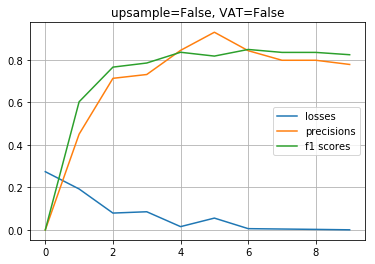

In [128]:
# Plot
plt.title("upsample={}, VAT={}".format(UPSAMPLE, VAT))
plt.plot(losses, label="losses")
plt.plot(precisions, label="precisions")
plt.plot(f1scores, label="f1 scores")
plt.grid()
plt.legend()
plt.show()

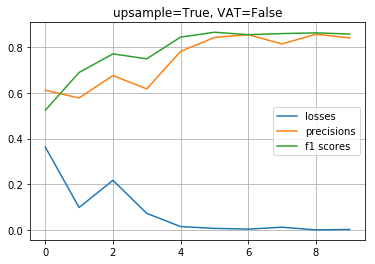

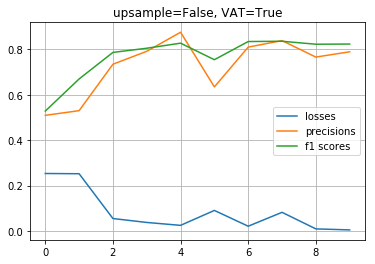

In [ ]:
# Plot
plt.title("upsample={}, VAT={}".format(UPSAMPLE, VAT))
plt.plot(losses, label="losses")
plt.plot(precisions, label="precisions")
plt.plot(f1scores, label="f1 scores")
plt.grid()
plt.legend()
plt.show()